To make a meaningful comparison I think I need to know more about my source behaviour. However I can still get a point spread function

In [1]:
from ParticleTracerClass import ParticleTracer
from phaseSpaceAnalyzer import SwarmSnapShot
import dill
from tqdm import tqdm
import time
from SwarmTracerClass import SwarmTracer
import warnings
import numpy as np
from ParticleClass import Swarm,Particle
from ParticleClass import Particle as ParticleBase
from ParticleTracerLatticeClass import ParticleTracerLattice
import matplotlib.pyplot as plt
import pathos as pa


LObject=70.0E-2
LImage=85E-2
LLensHardEdge=15.24e-2
rpLens=(5e-2,7.5e-2)
magnetWidth=(.0254,.0254*1.5)

fringeFrac=1.5
LFringe=fringeFrac*max(rpLens)
LLens=LLensHardEdge+2*LFringe
LObject-=LFringe
LImage-=LFringe

PTL=ParticleTracerLattice(v0Nominal=210.0,latticeType='injector',parallel=True)
PTL.add_Drift(LObject,ap=.07)
PTL.add_Halbach_Lens_Sim(rpLens,LLens,apFrac=.95,dipolesPerDim=4,magnetWidth=magnetWidth)
PTL.add_Drift(LImage*2,ap=.07)
assert PTL.elList[1].fringeFracOuter==fringeFrac and abs(PTL.elList[1].Lm-LLensHardEdge)<1e-9
PTL.end_Lattice()

xSigMin=abs(PTL.elList[-1].r1[0])
xSigMax=abs(PTL.elList[-1].r2[0])

# file=open('collectorLensLattice','wb')
# dill.dump(PTL,file)
# file=open('collectorLensLattice','rb')
# PTL=dill.load(file)
# file.close()

# Helper functions

In [2]:
class Interpolater:
    def __init__(self,swarm,PTL):
        self.swarm=swarm
        self.PTL=PTL
        self.endDriftLength=abs(self.PTL.elList[-1].r2[0]-self.PTL.elList[-1].r1[0])
    @staticmethod
    def get_Z_And_Y(particle):
        stepFrac=(abs(particle.qf[0])-xOrbit)/self.endDriftLength
        ySlope=particle.pf[1]/particle.pf[0]
        y=particle.qf[1]+stepFrac*self.endDriftLength*ySlope
        zSlope=particle.pf[2]/particle.pf[0]
        z=particle.qf[2]+stepFrac*self.endDriftLength*zSlope
        return z,y
    def __call__(self,xOrbit,maxRadius=np.inf):
        #xOrbit: Distance in orbit frame, POSITIVE to ease with analyze. Know that the tracing is done with x being negative
        #returns in units of mm
        assert -self.PTL.elList[-1].r2[0]>xOrbit>-self.PTL.elList[-1].r1[0]
        yList=[]
        zList=[]
        for particle in self.swarm:
            if particle.qf[0]<-xOrbit:
                stepFrac=(abs(particle.qf[0])-xOrbit)/self.endDriftLength
                ySlope=particle.pf[1]/particle.pf[0]
                y=particle.qf[1]+stepFrac*self.endDriftLength*ySlope
                zSlope=particle.pf[2]/particle.pf[0]
                z=particle.qf[2]+stepFrac*self.endDriftLength*zSlope
                yList.append(y)
                zList.append(z)
        yArr=np.asarray(yList)*1e3
        zArr=np.asarray(zList)*1e3
        rArr=np.sqrt(yArr**2+zArr**2)
        yArr=yArr[rArr<maxRadius]
        zArr=zArr[rArr<maxRadius]
        return yArr,zArr

## Load simulated particles and make swarm


number of particles: 2652


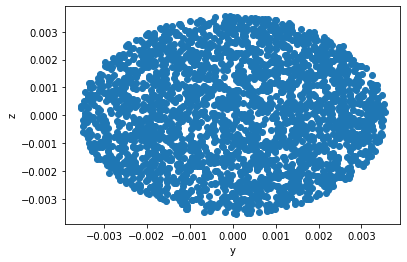

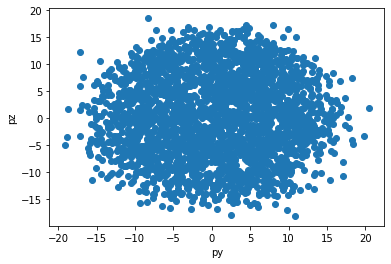

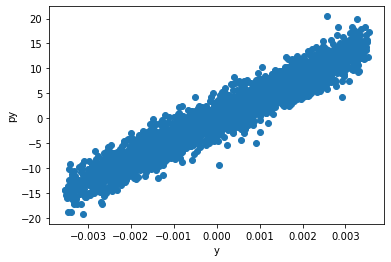

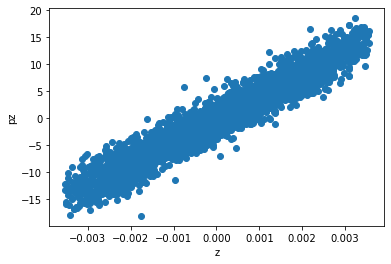

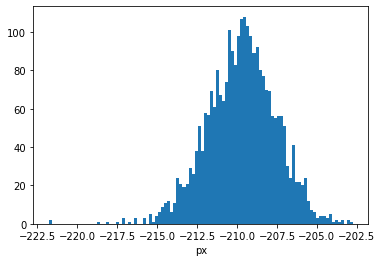

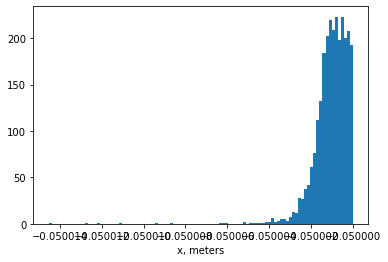

In [4]:
#load and rotate particles
data=np.loadtxt('nozzleSimulationParticles.txt')
print('number of particles:', len(data))
#coordinates need to be rotated because jeremy's definition to towards positive x
theta=np.pi
R=np.asarray([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]) 
# print(data[0]) #before 
for row in data:
  row[:2]=R@row[:2]
  row[3:5]=R@row[3:5]
  row[3]-=5
# print(data[0]) #after
initialParticles=[]
for row in data:
  qi=row[:3]
  pi=row[3:]
  initialParticles.append(Particle(qi=qi,pi=pi))
  
#plot some phase space stuff for sanity check. Namings for coordinates are different than jeremy
plt.scatter(data[:,1],data[:,2])
plt.xlabel('y')
plt.ylabel('z')
plt.show()

plt.scatter(data[:,4],data[:,5])
plt.xlabel('py')
plt.ylabel('pz')
plt.show()

plt.scatter(data[:,1],data[:,4])
plt.xlabel('y')
plt.ylabel('py')
plt.show()

plt.scatter(data[:,2],data[:,5])
plt.xlabel('z')
plt.ylabel('pz')
plt.show()

plt.hist(data[:,3],bins=100)
plt.xlabel('px')
plt.show()

plt.hist(data[:,0],bins=100)
plt.xlabel('x, meters')
plt.show()

In [5]:
#check that particles pass the skimmer, they all should. then add to swarm
xSkimmer=-16e-2
DSkimmer=2.54E-2
minGap=1e-3 #the swarm should fit snuggly in the skimmer. If there is not at least this gap, something weird is happening
gapList=[]
shiftedParticles=[]
for particleInitial in initialParticles:
  particleShifted=particleInitial.copy()
  dt=(xSkimmer-particleInitial.qi[0])/particleInitial.pi[0]
  particleShifted.qi=particleInitial.pi*dt
  r=np.linalg.norm(particleShifted.qi[1:])
  if r>DSkimmer/2:
    raise ValueError
  gapList.append(DSkimmer/2-r)
  shiftedParticles.append(particleShifted)
swarmInitial=Swarm()
swarmInitial.particles=shiftedParticles
if min(gapList)>minGap:
  print("particles do not fit snugly, or swarm size is small")
  print(min(gapList),minGap)

particles do not fit snugly, or swarm size is small
0.0016177374770397959 0.001


# Trace Swarm and make interp funcion

make a fake swarm for testing purpose 

In [5]:
# #make a fake swarm for testing only
# swarmTracer=SwarmTracer(PTL)
# particleTracer=ParticleTracer(PTL)
# numParticles=100_000
# h=5e-6
# v0=210.0
# sourceAngle=.08
# swarmInitial=swarmTracer.initalize_PseudoRandom_Swarm_In_Phase_Space(1e-9,sourceAngle*v0,1e-9,numParticles,circular=True)

In [6]:
#trace swarm and interpolate
swarmTracer=SwarmTracer(PTL)
h=5e-6 #time step, s
T=1.0 #s, sufficient for linear tracing through lens
fastMode=True
t=time.time()
swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmInitial,h,1.0,fastMode=fastMode,copySwarm=True,parallel=True)
print('time to run,s :',time.time()-t) #23
#count how many particle survived roughly
xEnd=PTL.elList[-1].r2[0]

numSurvived=sum([particle.qf[0]<xEnd+h*200.0*2 for particle in swarmTraced])
print('percent survived approx',int(1e2*numSurvived/swarmTraced.num_Particles()))

interpFunction=Interpolater(swarmTraced,PTL)
# PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False)

time to run,s : 2.7497670650482178
percent survived approx 78


In [8]:
def get_Floursence_Signal(x,binNum=100,maxRadius=np.inf):
  #given an x, return the signal that we would collect with a laser. Sensitive to binNum
  yArr,zArr=interpFunction(x,maxRadius=maxRadius)
  rArr=np.sqrt(yArr**2+zArr**2)

  signal,bins=np.histogram(rArr,bins=binNum)
  binSize=bins[1]-bins[0]
  rBinArr=bins[:-1]+binSize/2
  radiusWeight=1/(rBinArr*binSize*2*np.pi)
  signal=signal*radiusWeight
  return rBinArr,signal

# Analyze by circle of least confusion

1.6612255325532552 10.4597530784367
0.3142411708831787


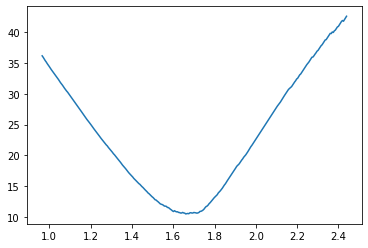

In [9]:
#don't attempt this on huge numbers of particles. Use a smaller number here like 100,000
from joblib import Parallel,delayed
import multiprocess
import scipy.interpolate as spi

#find circle of least confusion location
swarmTestMin=Swarm()
swarmTestMin.particles=swarmTraced.particles[:100_000]
interpFunctionMin=Interpolater(swarmTestMin,PTL)
xArr=np.linspace(xSigMin+1e-3,xSigMax-1e-3,300)
frac=.9 #fraction to define circle

def circleRadius(x):
  xCoords,yCoords=interpFunctionMin(x)
  r=np.sqrt(xCoords**2+yCoords**2)
#   return np.std(r)
  r=np.sort(r)
  assert len(r)>10 
#   print(int(frac*len(r)))
  rCutoff=r[int(frac*len(r))]
  return rCutoff

multiprocess.set_start_method('fork',force=True)
t=time.time()
with multiprocess.Pool(10) as pool:
    circleRadiusArr=np.asarray(pool.map(circleRadius,xArr))
interpFunc=spi.RBFInterpolator(xArr[:,np.newaxis],circleRadiusArr)
  

xArrDense=np.linspace(xArr[0],xArr[-1],10000)
yArrDense=interpFunc(xArrDense[:,np.newaxis])

xMin=xArrDense[np.argmin(yArrDense)]

print(xMin,np.min(yArrDense)) #1.721012101210121 4.2669987680085395
print(time.time()-t) 

plt.plot(xArr,circleRadiusArr)
# plt.plot(xArrDense,yArrDense,c='r')
plt.show()



1883 6.0


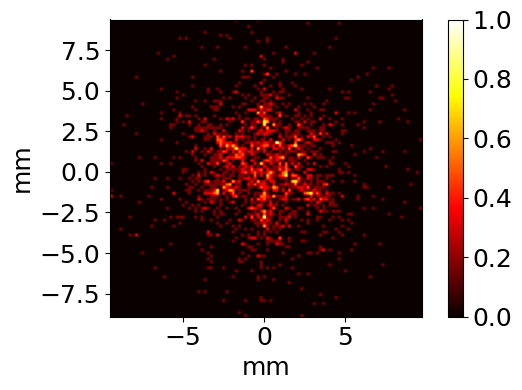

In [10]:
# %matplotlib tk
yArr,zArr=interpFunction(xMin)
rArr=np.sqrt(yArr**2+zArr**2)
rMax=10 #mm
yArr=yArr[rArr<rMax]
zArr=zArr[rArr<rMax]
image,yBins,zBins=np.histogram2d(yArr,zArr,bins=100)
print(int(image.sum()),image.max()) 
image=image/image.max()     

yMin=yBins[0]+(yBins[1]-yBins[0])/2
yMax=yBins[-1]-(yBins[1]-yBins[0])/2
zMin=zBins[0]+(zBins[1]-zBins[0])/2
zMax=zBins[-1]-(zBins[1]-zBins[0])/2
plt.figure(dpi=100)
plt.imshow(image,extent=[zMin,zMax,yMin,yMax],cmap='hot')#,interpolation='bicubic')#,vmin=0.0,vmax=25.6/10.0)
plt.xlabel('mm',fontsize=18)
plt.ylabel('mm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
bar=plt.colorbar()
bar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('focusImage_CircleOfLeastConfusion')
plt.show()



10.50788126885623


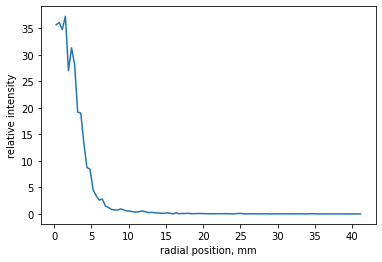

In [11]:
r,signal=get_Floursence_Signal(xMin)



rLeastConfuse=circleRadius(xMin)
print(rLeastConfuse)
# plt.figure(dpi=150)
plt.plot(r,signal)
plt.xlabel('radial position, mm')
plt.ylabel('relative intensity')

# plt.axvline(x=rLeastConfuse,c='black',linestyle=':')
# plt.savefig("focusIntensity_CircleOfLeastConfusion")
plt.show()


# Analyze by voigt fit

### helper functions for voigt fitting

[4.05514237e+01 1.32491827e-01 2.68225943e+00 3.78136676e-10]
fwhm: 6.316238280603049 num particles:


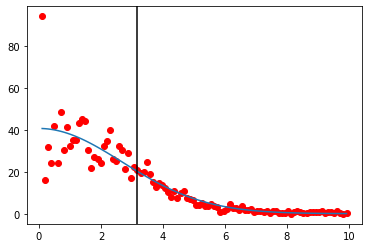

In [12]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
@np.vectorize
def voigt(r,a,b,sigma,gamma):
  #be very cautious about FWHM vs HWHM here for gamma. gamma for scipy is HWHM per the docs
  assert r>=0
  v0=voigt_profile(0,sigma,gamma)
  v=voigt_profile(r,sigma,gamma)/v0
  v=a*v+b
  return v

def fit_Signal_At_x(x,binNum=100,maxRadius=np.inf):
  r,signal=get_Floursence_Signal(x,binNum=binNum,maxRadius=maxRadius)
  guess=[signal.max(),signal.min(),1.0,1.0]
  bounds=[(0.0),(np.inf)]
  params=curve_fit(voigt,r,signal,p0=guess,bounds=bounds)[0]
  return params
def get_FWHM_At_x(x,binNum=100,maxRadius=np.inf):
  #be very cautious about FWHM vs HWHM here for gamma
  params=fit_Signal_At_x(x,maxRadius=maxRadius)
  sigma=params[2]
  gamma=params[3]
  fL=2*gamma
  fG=2*sigma*np.sqrt(2*np.log(2)) #np.log is natural logarithm 
  FWHM=.5346*fL+np.sqrt(.2166*fL**2 + fG**2)
  return FWHM
def plot_Fit_At_x(x,binNum=100,maxRadius=np.inf):
  r,signal=get_Floursence_Signal(x,binNum=binNum,maxRadius=maxRadius)
  FWHM=get_FWHM_At_x(x,binNum=binNum,maxRadius=maxRadius)
  params=fit_Signal_At_x(x,binNum=binNum,maxRadius=maxRadius)
  print(params)
  print('fwhm:',FWHM,'num particles:')#,voigt(FWHM/2,*params)/voigt(0,*params))
  plt.scatter(r,signal,c='red')
  plt.plot(r,voigt(r,*params))
  plt.axvline(x=FWHM/2,c='black')
  plt.show()
plot_Fit_At_x(xMin,binNum=100,maxRadius=10)

### visually find where the fit is reasonable

In [12]:
# import multiprocess as mp
# numSignalPoints=20
# xArr=np.linspace(xMin-5e-2,xMin+20e-2,numSignalPoints)
# for x in xArr:
#   print('X:',x)
#   try:
#       plot_Fit_At_x(x)#,maxRadius=5,binNum=30)
#   except:
#     print('failed')

# analyze by fit to Voigt CDF

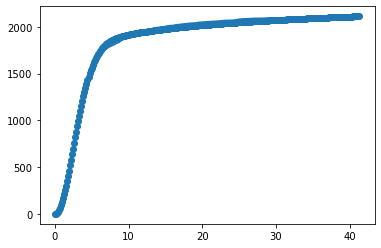

5.93922434755786

In [13]:
@np.vectorize
def voigt_CDF(r,rMax,numParticles,b,sigma,gamma):
  rIntPath=np.linspace(0,r,100)
  CDF=np.trapz(voigt(rIntPath,1,b,sigma,gamma)*rIntPath,x=rIntPath)
  rIntPath=np.linspace(0,rMax,100)
  CDF0=np.trapz(voigt(rIntPath,1,b,sigma,gamma)*rIntPath,x=rIntPath)
  return numParticles*CDF/CDF0
# voigt_CDF=np.vectorize(voigt_CDF)
def fit_Voigt_CDF(x,return_FitHelpers=False):
  yArr,zArr=interpFunction(x)
  rArr=np.sqrt(yArr**2+zArr**2)
  particleHist,rBins=np.histogram(rArr,bins=300)
  dr=rBins[1]-rBins[0]
  rPosArr=np.linspace(0,len(particleHist)*dr,len(particleHist))
  CDF=np.cumsum(particleHist)
  voigt_CDF_Fit_Func=lambda r,b,sigma,gamma: voigt_CDF(r,rPosArr.max(),CDF.max(),b,sigma,gamma)
  guess=[0,1.5,.1]
  bounds=[0,np.inf]
  params=curve_fit(voigt_CDF_Fit_Func,rPosArr,CDF,p0=guess,bounds=bounds)[0]
  if return_FitHelpers==True:
      return params,rPosArr,CDF,voigt_CDF_Fit_Func
  else:
    return params

def get_FWHM_At_x_From_CDF(x):
  #be very cautious about FWHM vs HWHM here for gamma
  b,sigma,gamma=fit_Voigt_CDF(x)
  fL=2*gamma
  fG=2*sigma*np.sqrt(2*np.log(2)) #np.log is natural logarithm 
  FWHM=.5346*fL+np.sqrt(.2166*fL**2 + fG**2)
  return FWHM
def plot_Voigt_CDF_Fit(x):
  params,rPosArr,CDF,fitFunc=fit_Voigt_CDF(x,return_FitHelpers=True)
  plt.scatter(rPosArr,fitFunc(rPosArr,*params))
  plt.plot(rPosArr,CDF)
  plt.show()
 
  
plot_Voigt_CDF_Fit(xMin)
get_FWHM_At_x_From_CDF(xMin)

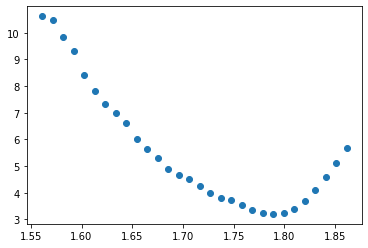

3.2086860862217463

In [15]:
import multiprocess as mp
xFWHMArr=np.linspace(xMin-.1,xMin+.2,30)
with mp.Pool(10) as pool:
  FWHMArr=np.asarray(pool.map(get_FWHM_At_x_From_CDF,xFWHMArr))
plt.scatter(xFWHMArr,FWHMArr)
plt.show()
np.min(FWHMArr)

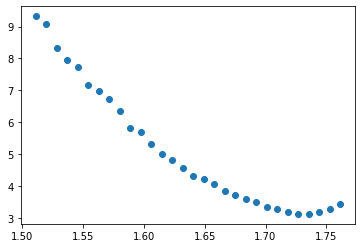

In [31]:
plt.scatter(xFWHMArr,FHWMArr)
plt.show()